### **1.0) Bibliotecas Necessárias**

In [18]:
#######################################################################
# Bibliotecas Principais
#######################################################################
import pandas as pd
from pathlib import Path
import pickle 
from datetime import datetime
from datetime import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display, Markdown   
from sklearn.ensemble import IsolationForest
from pywaffle import Waffle
import calplot
from scipy.stats.mstats import winsorize
from scipy import special
from pyod.models.iforest import IForest
from pyod.models.ocsvm import OCSVM

#### **2.0) Definições Globais**

In [2]:
########################################################################
# Definições Gerais
########################################################################
Arquivo = "https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/ambient_temperature_system_failure.csv"


#### **3.0) Leitura dos Dados Originais**

In [3]:
DadosBase = pd.read_csv ( Arquivo ) 
DadosBase = DadosBase.dropna(how = 'any', axis = 0)
dfTemp = DadosBase.copy()

#### **4.0) Ajustes e Criação de Novos Dados**

In [4]:
dfTemp = DadosBase.copy()
dfCompĺeto = DadosBase.copy()
dfTemp ["Registro"] = DadosBase.index
dfTemp = dfTemp.drop('timestamp', axis=1)
# dfTemp
# dfCompĺeto

#### **5.0) Modelo Isolation Forest (5%)**

In [6]:
X = dfTemp.to_numpy()
iforest = IForest(n_estimators=200, max_samples=0.6, max_features=0.9, contamination=0.05)
iforest.fit(X)

IForest(behaviour='old', bootstrap=False, contamination=0.05,
    max_features=0.9, max_samples=0.6, n_estimators=200, n_jobs=1,
    random_state=None, verbose=0)

In [7]:
probs = iforest.predict_proba(X)
dfCompĺeto ["Probabilidade" ] = probs[:, 1]
dfCompĺeto ["Probabilidade"] = dfCompĺeto["Probabilidade"].astype("float32")
dfCompĺeto ["value"] = dfCompĺeto["value"].astype("float32")
dfCompĺeto ["Probabilidade" ] = dfCompĺeto ["Probabilidade" ].round(2)
dfCompĺeto

,timestamp,value,Probabilidade
0,2013-07-04 00:00:00,69.880836,0.68
1,2013-07-04 01:00:00,71.220230,0.59
2,2013-07-04 02:00:00,70.877808,0.60
3,2013-07-04 03:00:00,68.959396,0.60
4,2013-07-04 04:00:00,69.283554,0.52
...,...,...,...
7262,2014-05-28 11:00:00,72.370209,0.44
7263,2014-05-28 12:00:00,72.172958,0.43
7264,2014-05-28 13:00:00,72.046562,0.48
7265,2014-05-28 14:00:00,71.825226,0.52


In [8]:
dfExtrato = pd.DataFrame()
dfExtrato["Probabilidade"] = 0.0
dfExtrato["Total"] = 0

dfExtrato ["Probabilidade"] = dfExtrato["Probabilidade"].astype("float32")
dfExtrato ["Total"] = dfExtrato["Total"].astype("int32")

In [9]:
Resultados =    {
                    "Probabilidade": [],
                    "Total" : []
                }   

jIndice = 0
jAux = 0.1
while (jAux <= 1.0):
      filtro = dfCompĺeto['Probabilidade'] == jAux
      Resultados ["Total"].append ( dfCompĺeto[filtro]["value"].count() )
      Resultados ["Probabilidade"].append (jAux)

      jAux += 0.01
      jAux = round (jAux, 2)
      jIndice += 1

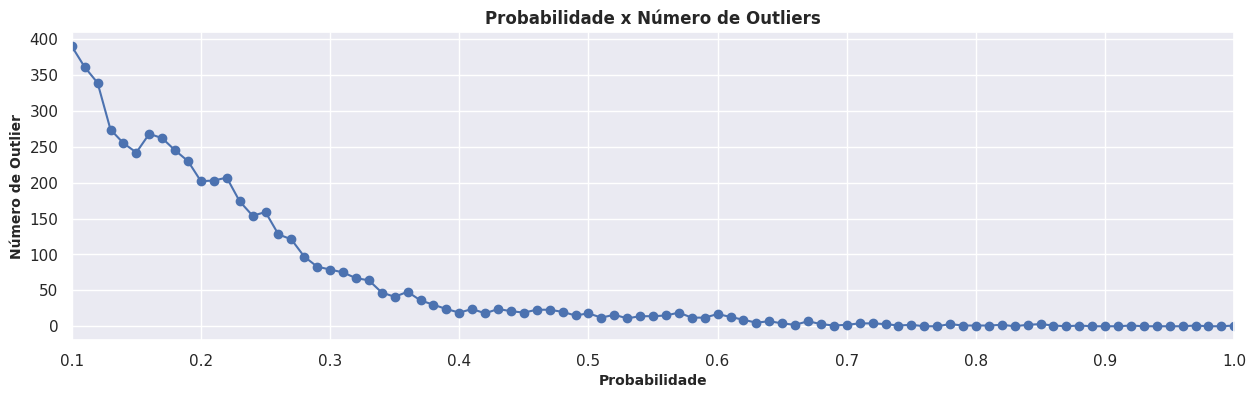

In [11]:
dfExtrato = pd.DataFrame(Resultados, columns=['Probabilidade', 'Total'])
plt.figure(figsize=(15, 4))
sns.set_theme(style="darkgrid")

plt.xlim (0.1, 1)
plt.plot( dfExtrato["Probabilidade"],  dfExtrato["Total"], marker = 'o')
plt.title("Probabilidade x Número de Outliers", fontsize=12, fontweight="bold" )
plt.ylabel('Número de Outlier', fontweight="bold", fontsize=10)
plt.xlabel ('Probabilidade', fontweight="bold", fontsize=10)
plt.show ()


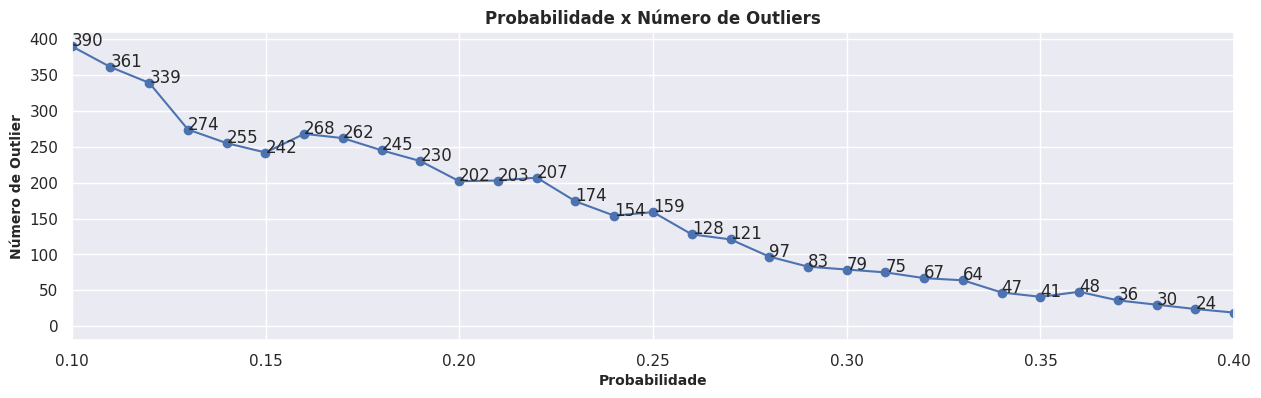

In [12]:
plt.figure(figsize=(15, 4))
sns.set_theme(style="darkgrid")

plt.xlim (0.1, 0.40)
plt.plot( dfExtrato["Probabilidade"],  dfExtrato["Total"], marker = 'o')
for iAux in enumerate ([
                        0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 
                        0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 
                        0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39,
                       ]):
    plt.text( iAux[1],  dfExtrato[dfExtrato["Probabilidade"] == iAux[1]]["Total"].values[0], '{:.0f}'.format(dfExtrato[dfExtrato["Probabilidade"] == iAux[1]]["Total"].values[0]))

plt.title("Probabilidade x Número de Outliers", fontsize=12, fontweight="bold" )
plt.ylabel('Número de Outlier', fontweight="bold", fontsize=10)
plt.xlabel ('Probabilidade', fontweight="bold", fontsize=10)
plt.show ()

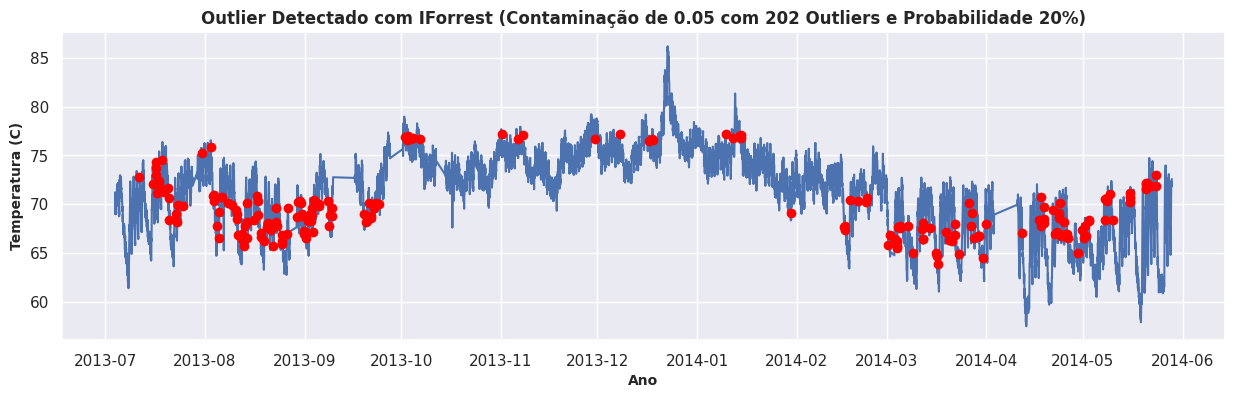

In [16]:
plt.figure(figsize=(15, 4))
sns.set_theme(style="darkgrid")

dfCompĺeto ["timestamp"] = pd.to_datetime(dfCompĺeto ["timestamp"]) 
plt.plot(dfCompĺeto['timestamp'] , dfCompĺeto['value'])
plt.plot (dfCompĺeto[dfCompĺeto["Probabilidade"]==0.20]["timestamp"], dfCompĺeto[dfCompĺeto["Probabilidade"]==0.20]["value"], 'o', color = 'red' )
plt.title("Outlier Detectado com IForrest (Contaminação de 0.05 com 202 Outliers e Probabilidade 20%)", fontsize=12, fontweight="bold" )
plt.ylabel('Temperatura (C)', fontweight="bold", fontsize=10)
plt.xlabel ('Ano', fontweight="bold", fontsize=10)
plt.show ()

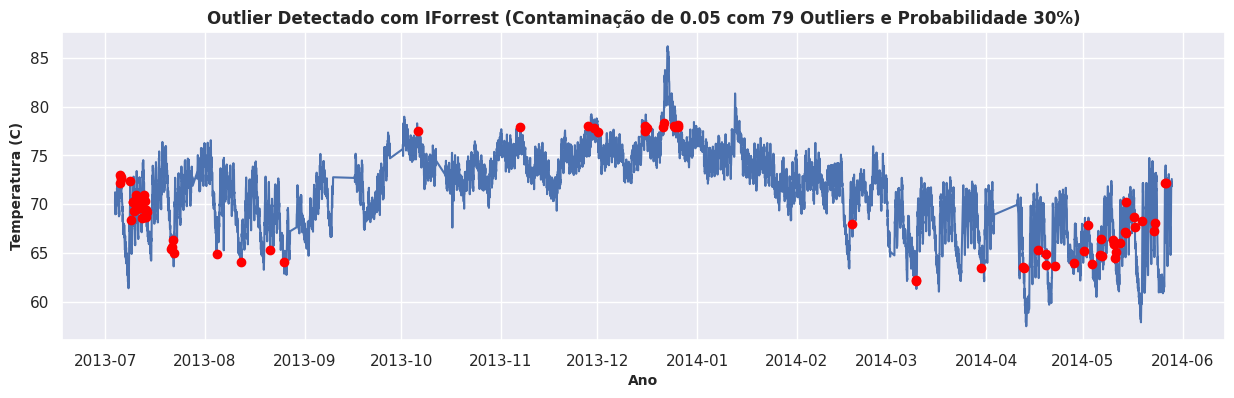

In [17]:
plt.figure(figsize=(15, 4))
sns.set_theme(style="darkgrid")

dfCompĺeto ["timestamp"] = pd.to_datetime(dfCompĺeto ["timestamp"]) 
plt.plot(dfCompĺeto['timestamp'] , dfCompĺeto['value'])
plt.plot (dfCompĺeto[dfCompĺeto["Probabilidade"]==0.30]["timestamp"], dfCompĺeto[dfCompĺeto["Probabilidade"]==0.30]["value"], 'o', color = 'red' )
plt.title("Outlier Detectado com IForrest (Contaminação de 0.05 com 79 Outliers e Probabilidade 30%)", fontsize=12, fontweight="bold" )
plt.ylabel('Temperatura (C)', fontweight="bold", fontsize=10)
plt.xlabel ('Ano', fontweight="bold", fontsize=10)
plt.show ()

#### **6.0) Modelo One Class SVM**

In [19]:
DadosBase = pd.read_csv ( Arquivo ) 
DadosBase = DadosBase.dropna(how = 'any', axis = 0)
dfTemp = DadosBase.copy()

In [20]:
dfTemp = DadosBase.copy()
dfCompĺeto = DadosBase.copy()
dfTemp ["Registro"] = DadosBase.index
dfTemp = dfTemp.drop('timestamp', axis=1)
# dfTemp
# dfCompĺeto

In [21]:
X = dfTemp.to_numpy()
ocsvm = OCSVM()
ocsvm.fit (X)   

OCSVM(cache_size=200, coef0=0.0, contamination=0.1, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.5, shrinking=True, tol=0.001,
   verbose=False)

In [22]:
probs = ocsvm.predict_proba(X)
dfCompĺeto ["Probabilidade" ] = probs[:, 1]
dfCompĺeto ["Probabilidade"] = dfCompĺeto["Probabilidade"].astype("float32")
dfCompĺeto ["value"] = dfCompĺeto["value"].astype("float32")
dfCompĺeto ["Probabilidade" ] = dfCompĺeto ["Probabilidade" ].round(2)
dfCompĺeto

,timestamp,value,Probabilidade
0,2013-07-04 00:00:00,69.880836,0.69
1,2013-07-04 01:00:00,71.220230,0.70
2,2013-07-04 02:00:00,70.877808,0.70
3,2013-07-04 03:00:00,68.959396,0.70
4,2013-07-04 04:00:00,69.283554,0.71
...,...,...,...
7262,2014-05-28 11:00:00,72.370209,0.70
7263,2014-05-28 12:00:00,72.172958,0.71
7264,2014-05-28 13:00:00,72.046562,0.70
7265,2014-05-28 14:00:00,71.825226,0.71


In [23]:
dfExtrato = pd.DataFrame()
dfExtrato["Probabilidade"] = 0.0
dfExtrato["Total"] = 0

dfExtrato ["Probabilidade"] = dfExtrato["Probabilidade"].astype("float32")
dfExtrato ["Total"] = dfExtrato["Total"].astype("int32")

In [24]:
Resultados =    {
                    "Probabilidade": [],
                    "Total" : []
                }   

jIndice = 0
jAux = 0.1
while (jAux <= 1.0):
      filtro = dfCompĺeto['Probabilidade'] == jAux
      Resultados ["Total"].append ( dfCompĺeto[filtro]["value"].count() )
      Resultados ["Probabilidade"].append (jAux)

      jAux += 0.01
      jAux = round (jAux, 2)
      jIndice += 1

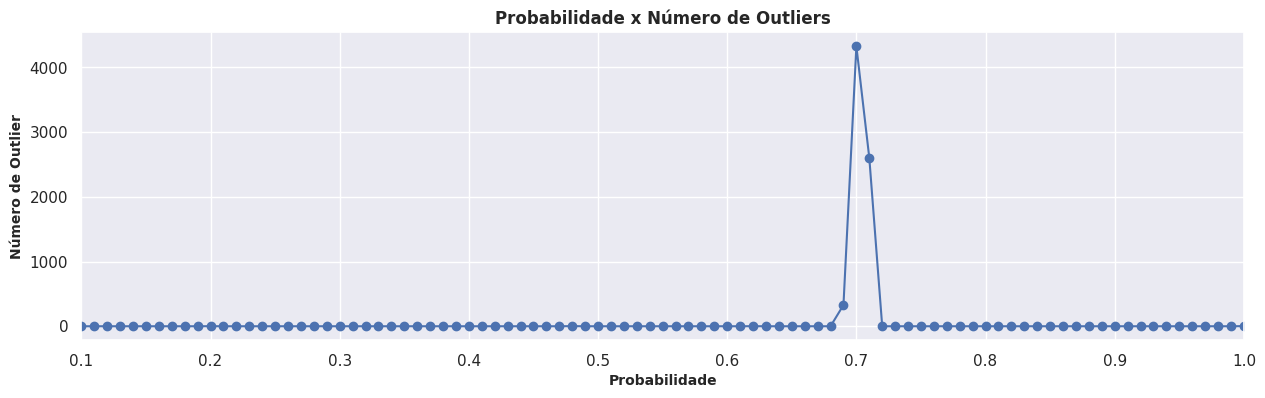

In [26]:
dfExtrato = pd.DataFrame(Resultados, columns=['Probabilidade', 'Total'])
plt.figure(figsize=(15, 4))
sns.set_theme(style="darkgrid")

plt.xlim (0.1, 1)
plt.plot( dfExtrato["Probabilidade"],  dfExtrato["Total"], marker = 'o')
plt.title("Probabilidade x Número de Outliers", fontsize=12, fontweight="bold" )
plt.ylabel('Número de Outlier', fontweight="bold", fontsize=10)
plt.xlabel ('Probabilidade', fontweight="bold", fontsize=10)
plt.show ()

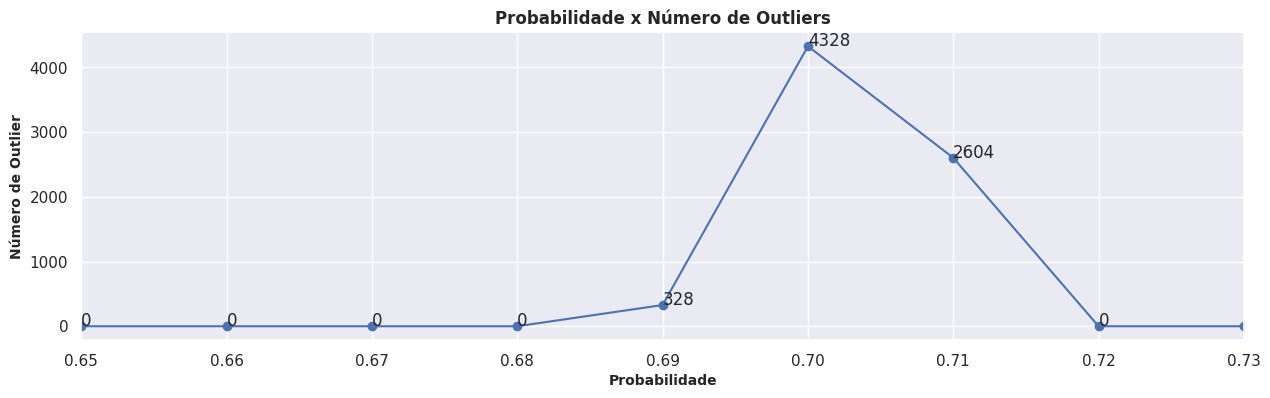

In [30]:
plt.figure(figsize=(15, 4))
sns.set_theme(style="darkgrid")

plt.xlim (0.65, 0.73)
plt.plot( dfExtrato["Probabilidade"],  dfExtrato["Total"], marker = 'o')
for iAux in enumerate ([0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72]):
    plt.text( iAux[1],  dfExtrato[dfExtrato["Probabilidade"] == iAux[1]]["Total"].values[0], '{:.0f}'.format(dfExtrato[dfExtrato["Probabilidade"] == iAux[1]]["Total"].values[0]))

plt.title("Probabilidade x Número de Outliers", fontsize=12, fontweight="bold" )
plt.ylabel('Número de Outlier', fontweight="bold", fontsize=10)
plt.xlabel ('Probabilidade', fontweight="bold", fontsize=10)
plt.show ()

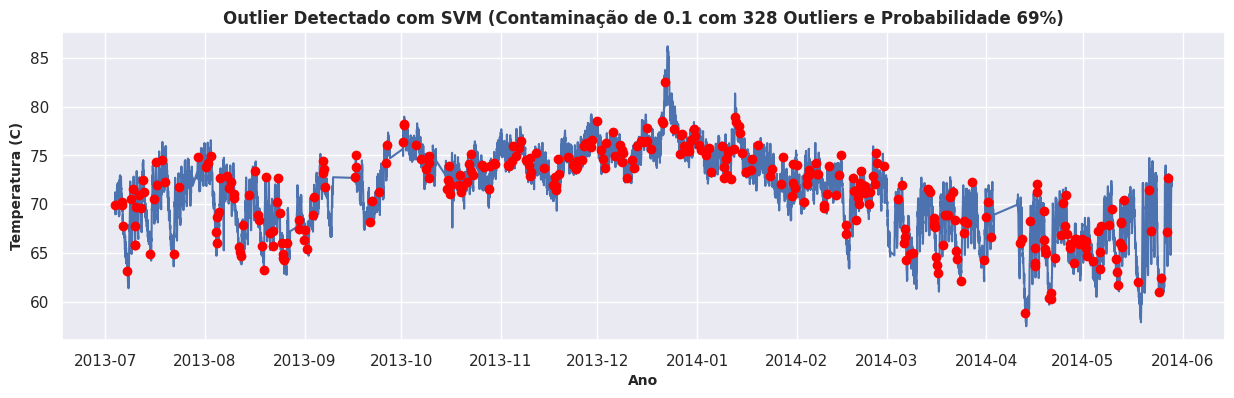

In [33]:
plt.figure(figsize=(15, 4))
sns.set_theme(style="darkgrid")

dfCompĺeto ["timestamp"] = pd.to_datetime(dfCompĺeto ["timestamp"]) 
plt.plot(dfCompĺeto['timestamp'] , dfCompĺeto['value'])
plt.plot (dfCompĺeto[dfCompĺeto["Probabilidade"]==0.69]["timestamp"], dfCompĺeto[dfCompĺeto["Probabilidade"]==0.69]["value"], 'o', color = 'red' )
plt.title("Outlier Detectado com SVM (Contaminação de 0.1 com 328 Outliers e Probabilidade 69%)", fontsize=12, fontweight="bold" )
plt.ylabel('Temperatura (C)', fontweight="bold", fontsize=10)
plt.xlabel ('Ano', fontweight="bold", fontsize=10)
plt.show ()